In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, Input, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.models import Model
import pandas as pd
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

# Récupère les données du jeux MNSIT Fashion

Description du jeu de données :  
https://www.kaggle.com/zalando-research/fashionmnist  
https://github.com/zalandoresearch/fashion-mnist

Description des étiquettes :
*   0 T-shirt/haut 
*   1 Pantalon
*   2 Pullover
*   3 Robe
*   4 Manteau
*   5 sandale
*   6 Chemise
*   7 Sneaker
*   8 Sac
*   9 Botine

In [ ]:
dataset_fashion_mnsit = tf.keras.datasets.fashion_mnist

In [ ]:
(X_train, y_train), (X_test, y_test) = dataset_fashion_mnsit.load_data()

Nombre de classes

In [ ]:
pd.DataFrame(y_train)[0].value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: 0, dtype: int64

Nous avons 10 classes réparties de manière homogène.

# Préparation des données (images)

Normalisation des données de l'image (afin d'avoir des valeurs de 0 à 1)

In [ ]:
X_train = X_train / 255
X_test = X_test / 255
print(f"Données entraintement: {X_train.shape}, Test: {X_test.shape}")

Données entraintement: (60000, 28, 28), Test: (10000, 28, 28)


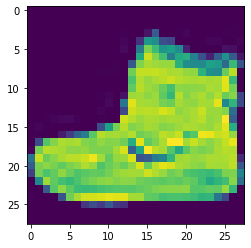

In [ ]:
plt.imshow(X_train[0])

In [ ]:
y_train[0]

9

Nous avons des images en niveau de gris. On doit rajouter une dimension ...

In [ ]:
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

# Modélisation

In [ ]:
mon_cnn = tf.keras.Sequential()

# 3 couches de convolution, avec Nb filtres progressif 32, 64 puis 128
mon_cnn.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(28, 28, 1), activation='relu'))
mon_cnn.add(MaxPooling2D(pool_size=(2, 2)))

mon_cnn.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(28, 28, 1), activation='relu'))
mon_cnn.add(MaxPooling2D(pool_size=(2, 2)))

mon_cnn.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(28, 28, 1), activation='relu'))
mon_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# remise à plat
mon_cnn.add(Flatten())

# Couche dense classique ANN
mon_cnn.add(Dense(512, activation='relu'))

# Couche de sortie (classes de 0 à 9)
mon_cnn.add(Dense(10, activation='softmax'))

Ajoute la condition d'early stopping

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
mon_cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
mon_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)               

In [ ]:
mon_cnn.fit(x=X_train, 
            y=y_train, 
            validation_data=(X_test, y_test), 
            epochs=25,
            callbacks=[early_stop])

Epoch 1/25
1875/1875 [==============================] - 59s 31ms/step - loss: 0.7872 - accuracy: 0.7077 - val_loss: 0.4386 - val_accuracy: 0.8408
Epoch 2/25
1875/1875 [==============================] - 58s 31ms/step - loss: 0.4102 - accuracy: 0.8490 - val_loss: 0.3833 - val_accuracy: 0.8625
Epoch 3/25
1875/1875 [==============================] - 58s 31ms/step - loss: 0.3345 - accuracy: 0.8752 - val_loss: 0.3404 - val_accuracy: 0.8740
Epoch 4/25
1875/1875 [==============================] - 58s 31ms/step - loss: 0.2958 - accuracy: 0.8887 - val_loss: 0.3470 - val_accuracy: 0.8747
Epoch 5/25
1875/1875 [==============================] - 58s 31ms/step - loss: 0.2694 - accuracy: 0.8987 - val_loss: 0.3225 - val_accuracy: 0.8844
Epoch 6/25
1875/1875 [==============================] - 58s 31ms/step - loss: 0.2422 - accuracy: 0.9092 - val_loss: 0.3194 - val_accuracy: 0.8862
Epoch 7/25
1875/1875 [==============================] - 57s 31ms/step - loss: 0.2329 - accuracy: 0.9115 - val_loss: 0.3220 -

# Evaluation du modèle

## Courbe de précision

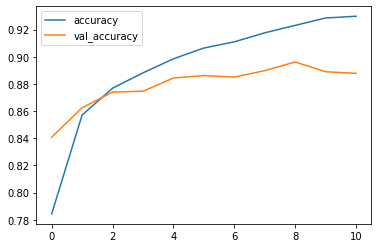

In [ ]:
losses = pd.DataFrame(mon_cnn.history.history)
losses[['accuracy', 'val_accuracy']].plot()

## Courbe de perte

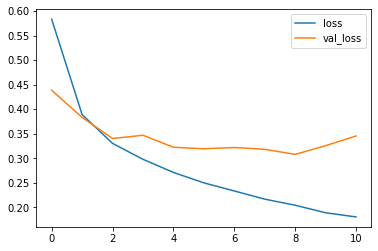

In [ ]:
losses[['loss', 'val_loss']].plot()

## Matrice de confusion

In [ ]:
pred = np.argmax(mon_cnn.predict(X_test), axis=1)

In [ ]:
confusion_matrix(y_test, pred)

array([[860,   1,  31,  34,   6,   1,  61,   0,   6,   0],
       [  3, 976,   1,  15,   3,   0,   0,   0,   2,   0],
       [ 13,   0, 853,  18,  78,   0,  38,   0,   0,   0],
       [ 20,   7,  16, 919,  24,   0,  10,   0,   1,   3],
       [  1,   2,  48,  27, 896,   0,  25,   0,   1,   0],
       [  0,   1,   0,   3,   0, 930,   0,  50,   2,  14],
       [140,   1,  92,  46, 165,   0, 543,   0,  13,   0],
       [  0,   0,   0,   0,   1,   2,   0, 969,   0,  28],
       [  6,   0,   2,   1,   7,   3,   6,   1, 974,   0],
       [  2,   0,   0,   0,   0,   5,   0,  35,   0, 958]])

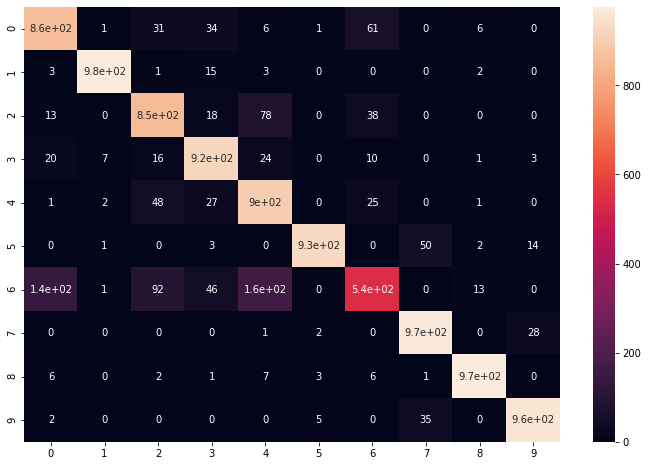

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(confusion_matrix(y_test, pred),annot=True)

On constate qu'il y a des erreurs/confusion surtout entre les chemises (6) et hauts (0). Ce n'est pas étonnant vu la qualité des images.

# Prédiction (exemple)

In [ ]:
img = X_train[0]
mon_cnn.predict(img.reshape(1,28,28,1))

array([[3.9226734e-07, 8.9244217e-08, 6.7499624e-11, 4.7707250e-08,
        1.1513226e-08, 1.3388344e-05, 9.8523687e-09, 7.1390239e-03,
        6.6544054e-08, 9.9284691e-01]], dtype=float32)

In [ ]:
np.argmax(mon_cnn.predict(img.reshape(1,28,28,1)), axis=-1)[0]

9